In [3]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
from tqdm.auto import tqdm # Optional: for progress bar

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def generate_simple_report(returns, benchmark=None):
    """
    生成简单的 QuantStats 报告，避免使用复杂的参数。
    """
    try:
        # 1. 确保数据类型正确
        returns = returns.astype(float)
        if not isinstance(returns.index, pd.DatetimeIndex):
            returns.index = pd.to_datetime(returns.index)
        
        if benchmark is not None:
            benchmark = benchmark.astype(float)
            if not isinstance(benchmark.index, pd.DatetimeIndex):
                benchmark.index = pd.to_datetime(benchmark.index)
            
            # 对齐数据
            benchmark = benchmark.reindex(returns.index)
        
        # 2. 生成报告
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            qs.reports.metrics(returns, benchmark=benchmark, mode='full')
            qs.reports.plots(returns, benchmark=benchmark, mode='full')
        
    except Exception as e:
        print(f"Error generating simple report: {e}")
        print("\nDebug information:")
        print(f"Returns shape: {returns.shape}")
        print(f"Returns index type: {type(returns.index)}")
        print(f"Returns dtype: {returns.dtype}")
        if benchmark is not None:
            print(f"Benchmark shape: {benchmark.shape}")
            print(f"Benchmark index type: {type(benchmark.index)}")
            print(f"Benchmark dtype: {benchmark.dtype}")

# --- Helper function to resolve strategy parameters ---
def get_strategy_param(strategy_specific_config, global_default_config, param_name, default_value=None):
    """
    Resolves a parameter value by checking strategy-specific config first,
    then global defaults, then a hardcoded default.
    """
    if param_name in strategy_specific_config:
        return strategy_specific_config[param_name]
    default_param_name = f"default_{param_name}"
    if default_param_name in global_default_config:
        return global_default_config[default_param_name]
    return default_value

# --- Step 1: Load Data ---
def load_data(cb_path, index_path):
    """Loads convertible bond and index data."""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        if 'trade_date' in df.index.names:
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else: 
             required_levels = ['code', 'trade_date']
             if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
             else: raise ValueError("Cannot set multi-index, missing columns for CB data.")
        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        if isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = index_df.index.dropna() # Remove NaT
            if not index_df.index.is_unique:
                index_df = index_df[~index_df.index.duplicated(keep='first')]
            index_df = index_df.sort_index() # Sort index after loading
            index_df.index = index_df.index.normalize() # Normalize to midnight
            print("Index DataFrame index cleaned, sorted, and normalized.")
        else:
            print("Warning: Index DataFrame does not have a DatetimeIndex.")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# --- Step 2: Filter Data ---
def filter_data(df_raw, start_date, end_date, strategy_filter_rules):
    """Applies date range and strategy-specific custom filters with detailed logging."""
    print(f"--- Filtering Data for strategy (Initial Filters: {strategy_filter_rules}) ---")
    if df_raw is None:
        print("  Error: Raw DataFrame is None.")
        return None
    try:
        df_temp_filtered = df_raw.copy()
        # Ensure 'trade_date' is a DatetimeIndex for filtering
        if 'trade_date' not in df_temp_filtered.index.names:
            if 'trade_date' in df_temp_filtered.columns:
                df_temp_filtered['trade_date'] = pd.to_datetime(df_temp_filtered['trade_date'])
                if 'code' in df_temp_filtered.columns and 'code' not in df_temp_filtered.index.names:
                    df_temp_filtered = df_temp_filtered.set_index(['trade_date', 'code'])
                elif 'code' in df_temp_filtered.index.names and 'trade_date' not in df_temp_filtered.index.names: 
                    df_temp_filtered = df_temp_filtered.set_index('trade_date', append=True)
                elif 'trade_date' not in df_temp_filtered.index.names: 
                    df_temp_filtered = df_temp_filtered.set_index('trade_date')
            else: 
                print("  Error: 'trade_date' column not found for date filtering.")
                return None
        
        if 'trade_date' in df_temp_filtered.index.names:
            trade_date_level = df_temp_filtered.index.get_level_values('trade_date')
            if not isinstance(trade_date_level, pd.DatetimeIndex):
                 df_temp_filtered.index = df_temp_filtered.index.set_levels(pd.to_datetime(trade_date_level), level='trade_date')
                 trade_date_level = df_temp_filtered.index.get_level_values('trade_date')
            date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        else: 
            print("  Warning: 'trade_date' not in index for date filtering, attempting column filter.")
            if 'trade_date' in df_temp_filtered.columns:
                 df_temp_filtered['trade_date'] = pd.to_datetime(df_temp_filtered['trade_date'])
                 date_mask = (df_temp_filtered['trade_date'] >= start_date) & (df_temp_filtered['trade_date'] <= end_date)
            else:
                 print("  Fatal Error: 'trade_date' not found for date filtering after attempts.")
                 return None

        df_filtered = df_temp_filtered[date_mask].copy()

        if df_filtered.empty:
            print(f"  Warning: No data remaining after date filtering ({start_date} to {end_date}). Shape: {df_filtered.shape}")
            return None
        print(f"  Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")
    except Exception as e:
        print(f"  Error during date filtering or initial index setup: {e}")
        return None

    df_filtered['filter_out'] = False
    print(f"  Initial eligible bond-days (before any filters): {len(df_filtered[~df_filtered['filter_out']])}")
    print("  Applying essential filters...")
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns:
        df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
        print(f"    After 'is_call' filter: {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
    else:
        print("    'is_call' column not found, skipping this essential filter.")

    if 'list_days' in df_filtered.columns:
        df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True
        print(f"    After 'list_days <= 3' filter: {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
    else:
        print("    'list_days' column not found, skipping this essential filter.")
    
    print("  Applying strategy-specific custom filters...")
    if strategy_filter_rules: 
        for i, rule in enumerate(strategy_filter_rules):
            if df_filtered[~df_filtered['filter_out']].empty:
                print(f"    Skipping remaining custom filters as no eligible data points left before rule '{rule}'.")
                break
            try:
                indices_matching_rule_in_full_df = df_filtered.query(rule).index
                df_filtered.loc[indices_matching_rule_in_full_df, 'filter_out'] = True
                print(f"    After custom filter rule [{i+1}] '{rule}': {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
            except Exception as e:
                print(f"    - Warning: Could not apply filter rule '{rule}'. Error: {e}. Eligible count remains {len(df_filtered[~df_filtered['filter_out']])}.")
    else:
        print("    No custom strategy filter rules provided.")
    
    final_eligible_count = len(df_filtered[~df_filtered['filter_out']])
    print(f"  Filtering complete. Final eligible bond-days: {final_eligible_count}")
    if final_eligible_count == 0:
        print("  Warning: No bonds eligible after applying all filters for this strategy.")
    return df_filtered

# --- Step 3: Calculate Scores ---
def calculate_scores(df, factor_weights):
    if df is None or 'filter_out' not in df.columns: return None
    df_eligible = df[~df['filter_out']].copy() 
    if df_eligible.empty:
        df['final_score'] = np.nan
        df['final_rank'] = np.nan
        for factor in factor_weights.keys(): df[f"{factor}_rank"] = np.nan
        return df

    df_scored = df.copy()
    df_scored['final_score'] = 0.0
    factors_used = list(factor_weights.keys())

    for factor in factors_used:
        if factor not in df_scored.columns:
            print(f"Warning: Factor '{factor}' not found in DataFrame columns. Skipping this factor.")
            df_scored[f"{factor}_rank"] = np.nan
            continue
        weight = factor_weights[factor]
        rank_col_name = f"{factor}_rank"
        df_eligible[factor] = pd.to_numeric(df_eligible[factor], errors='coerce')
        if 'trade_date' in df_eligible.index.names:
            ranks = df_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=False)
        else: 
            ranks = df_eligible.groupby('trade_date')[factor].rank(method='first', ascending=False)
        df_scored[rank_col_name] = ranks
        df_scored['final_score'] += df_scored[rank_col_name].fillna(0) * weight

    df_scored.loc[df_scored['filter_out'], 'final_score'] = np.nan
    if 'trade_date' in df_scored.index.names:
        df_scored['final_rank'] = df_scored.groupby(level='trade_date')['final_score'].rank(method='first', ascending=True, na_option='bottom')
    else:
        df_scored['final_rank'] = df_scored.groupby('trade_date')['final_score'].rank(method='first', ascending=True, na_option='bottom')
    df_scored.loc[df_scored['filter_out'], 'final_rank'] = np.nan
    return df_scored

# --- Helper Function: Apply Dynamic Stop-Profit/Stop-Loss Rules ---
def apply_dynamic_rules(df_scored, strategy_params):
    df_out = df_scored.copy()
    dynamic_sp_config = strategy_params.get('dynamic_stop_profit', {'enabled': False})
    dynamic_sl_config = strategy_params.get('dynamic_stop_loss', {'enabled': False})
    default_sp_pct = strategy_params.get('stop_profit_pct', 0.03) 
    default_sl_pct = strategy_params.get('stop_loss_pct', 0.05) 

    if dynamic_sp_config.get('enabled', False):
        base_factor_sp = dynamic_sp_config.get('base_factor', default_sp_pct) 
        formula_type_sp = dynamic_sp_config.get('formula_type', 'fixed')
        min_sp, max_sp = dynamic_sp_config.get('min_pct'), dynamic_sp_config.get('max_pct')
        if formula_type_sp == 'close_ratio_example':
            valid_close = df_out['close'].notna() & (df_out['close'] > 0)
            df_out['dynamic_sp_values'] = np.nan 
            df_out.loc[valid_close, 'dynamic_sp_values'] = base_factor_sp * (df_out.loc[valid_close, 'close'] / 150)
        else: df_out['dynamic_sp_values'] = base_factor_sp
        if min_sp is not None: df_out['dynamic_sp_values'] = df_out['dynamic_sp_values'].clip(lower=min_sp)
        if max_sp is not None: df_out['dynamic_sp_values'] = df_out['dynamic_sp_values'].clip(upper=max_sp)
        df_out['dynamic_sp_values'].fillna(base_factor_sp, inplace=True) 
        sp_col_name = 'dynamic_sp_values'
    else: 
        df_out['static_sp_values'] = default_sp_pct
        sp_col_name = 'static_sp_values'
    df_out['_sp_col_to_use'] = sp_col_name

    if dynamic_sl_config.get('enabled', False):
        base_factor_sl = dynamic_sl_config.get('base_factor', default_sl_pct)
        formula_type_sl = dynamic_sl_config.get('formula_type', 'fixed')
        min_sl, max_sl = dynamic_sl_config.get('min_pct'), dynamic_sl_config.get('max_pct')
        df_out['dynamic_sl_values'] = base_factor_sl 
        if min_sl is not None: df_out['dynamic_sl_values'] = df_out['dynamic_sl_values'].clip(lower=min_sl)
        if max_sl is not None: df_out['dynamic_sl_values'] = df_out['dynamic_sl_values'].clip(upper=max_sl)
        df_out['dynamic_sl_values'].fillna(base_factor_sl, inplace=True)
        sl_col_name = 'dynamic_sl_values'
    else: 
        df_out['static_sl_values'] = default_sl_pct
        sl_col_name = 'static_sl_values'
    df_out['_sl_col_to_use'] = sl_col_name
    return df_out

# --- Step 4: Calculate Returns & Turnover ---
def calculate_strategy_performance(
    df_scored: pd.DataFrame, strategy_hold_num: int, strategy_commission_rate: float, 
    sp_pct_col: str, sl_pct_col: str, strategy_params: dict 
) -> tuple:
    if df_scored is None or 'final_rank' not in df_scored.columns: return None, None
    if sp_pct_col not in df_scored.columns:
        df_scored[sp_pct_col] = strategy_params.get('stop_profit_pct', 0.03)
    if sl_pct_col not in df_scored.columns:
        df_scored[sl_pct_col] = strategy_params.get('stop_loss_pct', 0.05)

    df_perf = df_scored.copy()
    if not (isinstance(df_perf.index, pd.MultiIndex) and 
            all(name in df_perf.index.names for name in ['trade_date', 'code'])):
        print("Error: Perf calc DataFrame must have 'trade_date' and 'code' in MultiIndex.")
        return None, None

    grouped = df_perf.groupby(level='code')
    for col in ['open', 'close', 'high', 'low']: 
        if col not in df_perf.columns:
            print(f"Error: Essential column '{col}' missing for performance calculation.")
            return None, None
            
    df_perf['aft_open'] = grouped['open'].shift(-1)
    df_perf['aft_close'] = grouped['close'].shift(-1)
    df_perf['aft_high'] = grouped['high'].shift(-1)
    df_perf['aft_low'] = grouped['low'].shift(-1)
    
    df_perf['final_time_return'] = np.where(
        df_perf['close'] != 0, (df_perf['aft_close'] - df_perf['close']) / df_perf['close'], 0)
    df_perf['exit_type'] = 'EOD'

    _sp_pct = pd.to_numeric(df_perf[sp_pct_col], errors='coerce')
    valid_sp = _sp_pct.notna() & df_perf['close'].notna() & (df_perf['close'] != 0) & \
               df_perf['aft_open'].notna() & df_perf['aft_high'].notna()
    sp_target = df_perf['close'] * (1 + _sp_pct)

    cond_sp_open = valid_sp & (df_perf['aft_open'] >= sp_target)
    if cond_sp_open.any():
        df_perf.loc[cond_sp_open, 'final_time_return'] = (df_perf.loc[cond_sp_open, 'aft_open'] - df_perf.loc[cond_sp_open, 'close']) / df_perf.loc[cond_sp_open, 'close']
        df_perf.loc[cond_sp_open, 'exit_type'] = 'SP_Open'

    cond_sp_high = valid_sp & (df_perf['aft_high'] >= sp_target) & (df_perf['exit_type'] == 'EOD')
    if cond_sp_high.any():
        df_perf.loc[cond_sp_high, 'final_time_return'] = _sp_pct[cond_sp_high]
        df_perf.loc[cond_sp_high, 'exit_type'] = 'SP_High'

    _sl_pct = pd.to_numeric(df_perf[sl_pct_col], errors='coerce')
    valid_sl = _sl_pct.notna() & df_perf['close'].notna() & (df_perf['close'] != 0) & \
               df_perf['aft_open'].notna() & df_perf['aft_low'].notna()
    sl_target = df_perf['close'] * (1 - _sl_pct)

    cond_sl_open = valid_sl & (df_perf['aft_open'] <= sl_target) & (~df_perf['exit_type'].isin(['SP_Open', 'SP_High']))
    if cond_sl_open.any():
        df_perf.loc[cond_sl_open, 'final_time_return'] = (df_perf.loc[cond_sl_open, 'aft_open'] - df_perf.loc[cond_sl_open, 'close']) / df_perf.loc[cond_sl_open, 'close']
        df_perf.loc[cond_sl_open, 'exit_type'] = 'SL_Open'

    cond_sl_low = valid_sl & (df_perf['aft_low'] <= sl_target) & (~df_perf['exit_type'].isin(['SP_Open', 'SP_High', 'SL_Open']))
    if cond_sl_low.any():
        df_perf.loc[cond_sl_low, 'final_time_return'] = -_sl_pct[cond_sl_low]
        df_perf.loc[cond_sl_low, 'exit_type'] = 'SL_Low'

    df_perf['time_return'] = df_perf['final_time_return']
    df_perf['signal'] = np.where((df_perf['final_rank'] <= strategy_hold_num) & (~df_perf['final_rank'].isna()), 1, 0)

    portfolio_df = df_perf[df_perf['signal'] == 1].copy()
    if portfolio_df.empty: return None, None

    portfolio_df['time_return'] = pd.to_numeric(portfolio_df['time_return'], errors='coerce')
    trade_date_idx = portfolio_df.index.get_level_values('trade_date')
    if not isinstance(trade_date_idx, pd.DatetimeIndex):
        portfolio_df.index = portfolio_df.index.set_levels(pd.to_datetime(trade_date_idx), level='trade_date')
    daily_returns = portfolio_df.groupby(level='trade_date')['time_return'].mean().sort_index()

    pos_df = df_perf['signal'].unstack(level='code', fill_value=0).astype(int)
    turnover = pos_df.diff().fillna(0).abs().sum(axis=1)
    prev_pos_count = pos_df.shift(1).sum(axis=1)
    curr_pos_count = pos_df.sum(axis=1)
    total_exp_factor = (prev_pos_count + curr_pos_count).replace(0, np.nan)
    
    daily_cost_pct_raw = np.where(total_exp_factor.notna() & (total_exp_factor != 0), (turnover * strategy_commission_rate) / total_exp_factor, 0)
    daily_cost_pct = pd.Series(daily_cost_pct_raw, index=total_exp_factor.index)

    if not daily_cost_pct.empty and not pos_df.empty and len(daily_cost_pct) > 0:
        first_day = daily_cost_pct.index[0]
        if total_exp_factor.loc[first_day] > 0 and curr_pos_count.loc[first_day] > 0:
             daily_cost_pct.loc[first_day] = 0.5 * strategy_commission_rate * curr_pos_count.loc[first_day] / total_exp_factor.loc[first_day]
        elif curr_pos_count.loc[first_day] == 0: daily_cost_pct.loc[first_day] = 0

    res = pd.DataFrame({'time_return': daily_returns}).fillna(0)
    res['cost'] = daily_cost_pct.reindex(res.index).fillna(0)
    res['net_return'] = (1 + res['time_return']) * (1 - res['cost']) - 1
    
    daily_turnover_raw = np.where(curr_pos_count.notna() & (curr_pos_count != 0), turnover / curr_pos_count, 0)
    avg_daily_turnover = pd.Series(daily_turnover_raw, index=curr_pos_count.index).mean()
    return res['net_return'], avg_daily_turnover


# --- SIMPLIFIED Helper function to prepare benchmark series ---
def _prepare_benchmark_series(raw_benchmark_series: pd.Series, strategy_returns_index: pd.DatetimeIndex, benchmark_name: str):
    """
    Prepares benchmark series for QuantStats, assuming raw_benchmark_series contains DAILY RETURNS.
    1. Ensures DatetimeIndex, sorts, normalizes, and makes unique.
    2. Reindexes to strategy returns and fills NaNs with 0.
    3. Handles potential inf values.
    """
    if raw_benchmark_series is None or raw_benchmark_series.empty:
        print(f"  Benchmark series '{benchmark_name}' is None or empty. Cannot prepare.")
        return None

    benchmark_s = raw_benchmark_series.copy() 

    if not isinstance(benchmark_s.index, pd.DatetimeIndex):
        try:
            benchmark_s.index = pd.to_datetime(benchmark_s.index)
        except Exception as e:
            print(f"  Error converting benchmark '{benchmark_name}' index to DatetimeIndex: {e}. Cannot prepare benchmark.")
            return None
    
    benchmark_s.index = benchmark_s.index.dropna() # Remove NaT
    if not benchmark_s.index.is_unique:
        benchmark_s = benchmark_s[~benchmark_s.index.duplicated(keep='first')]
    benchmark_s = benchmark_s.sort_index()
    benchmark_s.index = benchmark_s.index.normalize() # Normalize to midnight
    
    if np.isinf(benchmark_s).any().any(): 
        print(f"  Warning: Benchmark '{benchmark_name}' contains inf values. Replacing with 0 before alignment.")
        benchmark_s.replace([np.inf, -np.inf], 0, inplace=True)

    print(f"  Benchmark '{benchmark_name}' (mean: {benchmark_s.mean():.4f}, std: {benchmark_s.std():.4f}) is assumed to be daily returns. Aligning with strategy dates.")
    # Ensure strategy_returns_index is also clean before reindexing
    clean_strategy_returns_index = strategy_returns_index.dropna()
    if not clean_strategy_returns_index.is_unique:
        clean_strategy_returns_index = clean_strategy_returns_index[~clean_strategy_returns_index.duplicated(keep='first')]
    clean_strategy_returns_index = clean_strategy_returns_index.sort_values().normalize()
    
    aligned_benchmark = benchmark_s.reindex(clean_strategy_returns_index).fillna(0) 
    
    if aligned_benchmark.isnull().all(): 
        print(f"  Warning: Benchmark '{benchmark_name}' alignment resulted in all NaNs (possibly no overlapping dates). Disabling benchmark for metrics.")
        return None
        
    return aligned_benchmark.sort_index() 

# --- Function to Calculate Metrics (Uses simplified _prepare_benchmark_series) ---
def get_performance_metrics(returns, raw_benchmark_series, benchmark_name, avg_turnover):
    metrics = {}
    if returns is None or not isinstance(returns, pd.Series) or returns.isnull().all() or len(returns) < 2:
        return {
             'Cumulative Return': np.nan, 'CAGR': np.nan, 'Sharpe': np.nan,
             'Prob. Sharpe Ratio': np.nan, 'Smart Sharpe': np.nan, 'Sortino': np.nan,
             'Max Drawdown': np.nan, 'Longest DD Days': np.nan, 'Volatility (ann.)': np.nan,
             'Information Ratio': np.nan, 'Beta': np.nan, 'Alpha': np.nan,
             'Avg Daily Turnover': avg_turnover if avg_turnover is not None else np.nan
        }

    # Rigorous cleaning for returns series
    if not isinstance(returns.index, pd.DatetimeIndex):
        returns.index = pd.to_datetime(returns.index)
    returns.index = returns.index.dropna() 
    if not returns.index.is_unique:
        returns = returns[~returns.index.duplicated(keep='first')]
    returns = returns.sort_index()
    returns.index = returns.index.normalize()
    returns = returns.astype(float).replace([np.inf, -np.inf], 0).fillna(0) 
    
    aligned_benchmark = None
    if raw_benchmark_series is not None and not raw_benchmark_series.empty:
        aligned_benchmark = _prepare_benchmark_series(raw_benchmark_series, returns.index, benchmark_name)
        if aligned_benchmark is not None:
            aligned_benchmark = aligned_benchmark.astype(float).replace([np.inf, -np.inf], 0).fillna(0) 
    
    if returns.empty or returns.std() == 0: 
        print(f"  Warning: Strategy returns for '{benchmark_name if benchmark_name else 'Unknown'}' are flat or empty after cleaning. Most metrics will be NaN.")
    
    try: metrics['Cumulative Return'] = qs.stats.comp(returns)
    except Exception: metrics['Cumulative Return'] = np.nan
    try: metrics['CAGR'] = qs.stats.cagr(returns)
    except Exception: metrics['CAGR'] = np.nan
    try: metrics['Sharpe'] = qs.stats.sharpe(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None) 
    except Exception: metrics['Sharpe'] = np.nan
    try: metrics['Prob. Sharpe Ratio'] = qs.stats.probabilistic_sharpe_ratio(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Prob. Sharpe Ratio'] = np.nan
    try: metrics['Smart Sharpe'] = qs.stats.smart_sharpe(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Smart Sharpe'] = np.nan
    try: metrics['Sortino'] = qs.stats.sortino(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Sortino'] = np.nan
    try: metrics['Max Drawdown'] = qs.stats.max_drawdown(returns)
    except Exception: metrics['Max Drawdown'] = np.nan
    try:
        dd_info = qs.stats.drawdown_details(returns)
        if dd_info is not None and not dd_info.empty and 'Days' in dd_info.columns:
            metrics['Longest DD Days'] = int(dd_info['Days'].max())
        elif dd_info is not None and dd_info.empty: metrics['Longest DD Days'] = 0
        else: metrics['Longest DD Days'] = np.nan
    except Exception: metrics['Longest DD Days'] = np.nan
    try: metrics['Volatility (ann.)'] = qs.stats.volatility(returns)
    except Exception: metrics['Volatility (ann.)'] = np.nan

    if aligned_benchmark is not None:
        try: metrics['Information Ratio'] = qs.stats.information_ratio(returns, aligned_benchmark)
        except Exception: metrics['Information Ratio'] = np.nan
        try: metrics['Beta'] = qs.stats.beta(returns, aligned_benchmark)
        except Exception: metrics['Beta'] = np.nan
        try: metrics['Alpha'] = qs.stats.alpha(returns, aligned_benchmark) 
        except Exception: metrics['Alpha'] = np.nan
    else:
        metrics['Information Ratio'], metrics['Beta'], metrics['Alpha'] = np.nan, np.nan, np.nan
        if raw_benchmark_series is not None: 
            print(f"  Benchmark metrics (IR, Beta, Alpha) for '{benchmark_name}' are NaN due to processing/alignment issues or invalid benchmark data.")

    metrics['Avg Daily Turnover'] = avg_turnover if avg_turnover is not None else np.nan
    for key, value in metrics.items():
        if isinstance(value, (float, np.number)) and not np.isnan(value):
             if key == 'Longest DD Days': metrics[key] = int(value)
             else: metrics[key] = round(value, 4)
        elif np.isnan(value): metrics[key] = np.nan
    return metrics

# --- Helper Function to Generate Full Report (Uses simplified _prepare_benchmark_series) ---
def generate_full_report_for_strategy(strategy_name, factor_weights_dict, df_filtered_base, index_df_base, 
                                      strategy_params, global_config_for_report): 
    print(f"\n--- Generating Full Report for Strategy: {strategy_name} (Weights: {factor_weights_dict}) ---")
    if df_filtered_base is None: print("Error: Base filtered data for report is missing."); return

    print("Calculating scores for report...")
    df_scored = calculate_scores(df_filtered_base.copy(), factor_weights_dict) 
    if df_scored is None: print("Error: Scoring failed for report."); return

    df_scored_with_rules = apply_dynamic_rules(df_scored, strategy_params)
    sp_col = df_scored_with_rules['_sp_col_to_use'].iloc[0] if not df_scored_with_rules.empty and '_sp_col_to_use' in df_scored_with_rules.columns else 'static_sp_values'
    sl_col = df_scored_with_rules['_sl_col_to_use'].iloc[0] if not df_scored_with_rules.empty and '_sl_col_to_use' in df_scored_with_rules.columns else 'static_sl_values'
    
    print("Calculating performance for report...")
    strat_hold_num = strategy_params.get('hold_num')
    strat_commission_rate = strategy_params.get('commission_rate')

    net_returns, _ = calculate_strategy_performance(
        df_scored_with_rules, strat_hold_num, strat_commission_rate,
        sp_pct_col=sp_col, sl_pct_col=sl_col, strategy_params=strategy_params 
    )

    if net_returns is None or not isinstance(net_returns, pd.Series) or net_returns.empty:
        print("Error: Performance calculation failed for report. Cannot generate report.")
        return

    # Clean net_returns for QS report
    if not isinstance(net_returns.index, pd.DatetimeIndex):
        net_returns.index = pd.to_datetime(net_returns.index)
    net_returns.index = net_returns.index.dropna()
    if not net_returns.index.is_unique:
        net_returns = net_returns[~net_returns.index.duplicated(keep='first')]
    net_returns = net_returns.sort_index()
    net_returns.index = net_returns.index.normalize()
    clean_net_returns = net_returns.astype(float).replace([np.inf, -np.inf], 0).fillna(0)


    print("\nGenerating QuantStats full report...")
    try:
        # For qs.reports.full, pass the raw benchmark column directly as per user request for older QS versions
        benchmark_series_for_qs_report = None
        strat_benchmark_col_name = strategy_params.get('benchmark_col')
        if strat_benchmark_col_name and strat_benchmark_col_name in index_df_base.columns:
            benchmark_series_for_qs_report = index_df_base[strat_benchmark_col_name].copy() # Get raw series
            # Clean the benchmark series before passing to QuantStats
            if not isinstance(benchmark_series_for_qs_report.index, pd.DatetimeIndex):
                benchmark_series_for_qs_report.index = pd.to_datetime(benchmark_series_for_qs_report.index)
            benchmark_series_for_qs_report.index = benchmark_series_for_qs_report.index.dropna()
            if not benchmark_series_for_qs_report.index.is_unique:
                 benchmark_series_for_qs_report = benchmark_series_for_qs_report[~benchmark_series_for_qs_report.index.duplicated(keep='first')]
            benchmark_series_for_qs_report = benchmark_series_for_qs_report.sort_index()
            benchmark_series_for_qs_report.index = benchmark_series_for_qs_report.index.normalize()
            benchmark_series_for_qs_report = benchmark_series_for_qs_report.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
            print(f"  Using benchmark '{strat_benchmark_col_name}' directly for {strategy_name}'s report after cleaning.")
        else:
            print(f"  Warning: Benchmark column '{strat_benchmark_col_name}' for strategy '{strategy_name}' (for report) not found. Report will lack benchmark.")
        
        if clean_net_returns.empty or clean_net_returns.std() == 0:
            print(f"Warning: Strategy '{strategy_name}' returns are empty or flat after cleaning. QuantStats report may fail or be uninformative.")

        qs.reports.full(clean_net_returns, 
                        benchmark=benchmark_series_for_qs_report, # Pass the directly sourced and cleaned benchmark
                        periods_per_year=252,
                        title=f"QuantStats Report for {strategy_name}")
    except Exception as e:
        print(f"Error generating QuantStats report for {strategy_name}: {e}")
    print(f"--- Report Generation Attempt Complete for {strategy_name} ---")


# --- Function: Multi-Strategy Rebalancing (Uses simplified _prepare_benchmark_series) ---
def run_rebalancing_strategy(
    pre_calculated_strategy_returns: dict, 
    df_index: pd.DataFrame, 
    global_config: dict, 
    rebalance_freq_days: int
):
    print(f"\n--- Running Rebalancing Strategy (Frequency: {rebalance_freq_days} days) ---")
    
    if not pre_calculated_strategy_returns:
        print("Error (Rebalancing): No pre-calculated strategy returns provided. Cannot perform rebalancing.")
        return None, None

    cleaned_returns_for_rebalance = {}
    for name, returns_series in pre_calculated_strategy_returns.items():
        if returns_series is None or returns_series.empty:
            print(f"Warning (Rebalancing): Pre-calculated returns for '{name}' are empty. Skipping this strategy for rebalance.")
            continue
        
        s = returns_series.copy()
        if not isinstance(s.index, pd.DatetimeIndex):
            s.index = pd.to_datetime(s.index)
        s.index = s.index.dropna()
        if not s.index.is_unique:
            s = s[~s.index.duplicated(keep='first')]
        s = s.sort_index()
        s.index = s.index.normalize()
        s = s.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
        if not s.empty:
            cleaned_returns_for_rebalance[name] = s
        else:
            print(f"Warning (Rebalancing): Pre-calculated returns for '{name}' became empty after cleaning. Skipping.")

    if not cleaned_returns_for_rebalance:
        print("Error (Rebalancing): No valid pre-calculated strategy returns after cleaning. Cannot perform rebalancing.")
        return None, None

    returns_df_for_rebalance = pd.DataFrame(cleaned_returns_for_rebalance).fillna(0)
    if not isinstance(returns_df_for_rebalance.index, pd.DatetimeIndex): # Should be DatetimeIndex from above
        returns_df_for_rebalance.index = pd.to_datetime(returns_df_for_rebalance.index)
    
    returns_df_for_rebalance.index = returns_df_for_rebalance.index.dropna() 
    if not returns_df_for_rebalance.index.is_unique:
        print("Warning: Combined returns DataFrame index for rebalancing is not unique. Keeping first.")
        returns_df_for_rebalance = returns_df_for_rebalance[~returns_df_for_rebalance.index.duplicated(keep='first')]
    returns_df_for_rebalance = returns_df_for_rebalance.sort_index() # Should already be sorted and normalized
    
    num_strategies = len(returns_df_for_rebalance.columns)
    if num_strategies == 0: 
        print("Error (Rebalancing): No strategies left after cleaning returns for rebalancing.")
        return None, None

    all_trade_dates = returns_df_for_rebalance.index 
    if all_trade_dates.empty:
        print("Error (Rebalancing): No valid trade dates for rebalancing. Cannot proceed.")
        return None, None
        
    portfolio_daily_returns = pd.Series(index=all_trade_dates, dtype=float) 
    current_weights = pd.Series([1/num_strategies] * num_strategies, index=returns_df_for_rebalance.columns)

    for i, trade_date in enumerate(all_trade_dates): 
        if i % rebalance_freq_days == 0: 
            current_weights = pd.Series([1/num_strategies] * num_strategies, index=returns_df_for_rebalance.columns)
        
        daily_indiv_returns = returns_df_for_rebalance.loc[trade_date]
        portfolio_daily_returns.loc[trade_date] = (current_weights * daily_indiv_returns).sum()
        
        if (i + 1) % rebalance_freq_days != 0 and (i + 1) < len(all_trade_dates):
            capital_eod = current_weights * (1 + daily_indiv_returns)
            total_capital_eod = capital_eod.sum()
            if total_capital_eod != 0 and not np.isnan(total_capital_eod):
                current_weights = capital_eod / total_capital_eod
            else: 
                current_weights = pd.Series([1/num_strategies] * num_strategies, index=returns_df_for_rebalance.columns)

    # Rigorous cleaning for the final rebalanced portfolio returns
    rebalanced_portfolio_returns = portfolio_daily_returns.fillna(0)
    if not isinstance(rebalanced_portfolio_returns.index, pd.DatetimeIndex):
        rebalanced_portfolio_returns.index = pd.to_datetime(rebalanced_portfolio_returns.index)
    rebalanced_portfolio_returns.index = rebalanced_portfolio_returns.index.dropna() 
    if not rebalanced_portfolio_returns.index.is_unique:
        rebalanced_portfolio_returns = rebalanced_portfolio_returns[~rebalanced_portfolio_returns.index.duplicated(keep='first')]
    rebalanced_portfolio_returns = rebalanced_portfolio_returns.sort_index()
    rebalanced_portfolio_returns.index = rebalanced_portfolio_returns.index.normalize() 
    rebalanced_portfolio_returns = rebalanced_portfolio_returns.astype(float) 
    rebalanced_portfolio_returns.replace([np.inf, -np.inf], 0, inplace=True) 
    rebalanced_portfolio_returns = rebalanced_portfolio_returns.fillna(0) 

    print(f"Rebalanced portfolio returns generated and cleaned (Length: {len(rebalanced_portfolio_returns)})")

    print("\n--- Performance of Rebalanced Meta-Strategy ---")
    raw_benchmark_for_rebal_metrics = None
    rebal_report_benchmark_col = global_config.get('default_benchmark_col', 'index_jsl')
    if rebal_report_benchmark_col in df_index.columns:
        raw_benchmark_for_rebal_metrics = df_index[rebal_report_benchmark_col] 
    else:
        print(f"Warning (Rebalancing): Default benchmark column '{rebal_report_benchmark_col}' for rebalanced report not found.")

    rebalanced_metrics = get_performance_metrics(rebalanced_portfolio_returns.copy(), 
                                                 raw_benchmark_for_rebal_metrics, 
                                                 rebal_report_benchmark_col, 
                                                 avg_turnover=np.nan)

    print("Metrics for Rebalanced Portfolio:")
    if rebalanced_metrics:
        for k, v in rebalanced_metrics.items(): print(f"  {k}: {v}")
    else: print("  Could not calculate metrics for the rebalanced portfolio.")

    if rebalanced_portfolio_returns is not None and not rebalanced_portfolio_returns.empty:
        clean_rebalanced_returns = rebalanced_portfolio_returns.copy() # Already cleaned
        
        benchmark_for_qs_rebal_report = None
        if rebal_report_benchmark_col in df_index.columns:
            benchmark_for_qs_rebal_report = df_index[rebal_report_benchmark_col].copy()
            # Apply the same rigorous cleaning to the benchmark for the report
            if not isinstance(benchmark_for_qs_rebal_report.index, pd.DatetimeIndex):
                benchmark_for_qs_rebal_report.index = pd.to_datetime(benchmark_for_qs_rebal_report.index)
            benchmark_for_qs_rebal_report.index = benchmark_for_qs_rebal_report.index.dropna()
            if not benchmark_for_qs_rebal_report.index.is_unique:
                benchmark_for_qs_rebal_report = benchmark_for_qs_rebal_report[~benchmark_for_qs_rebal_report.index.duplicated(keep='first')]
            benchmark_for_qs_rebal_report = benchmark_for_qs_rebal_report.sort_index()
            benchmark_for_qs_rebal_report.index = benchmark_for_qs_rebal_report.index.normalize()
            benchmark_for_qs_rebal_report = benchmark_for_qs_rebal_report.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
            # Reindex to match the strategy returns, AFTER basic cleaning of benchmark itself
            benchmark_for_qs_rebal_report = benchmark_for_qs_rebal_report.reindex(clean_rebalanced_returns.index).fillna(0)


        print("\n--- Debug: Inspecting rebalanced_portfolio_returns (cleaned for QS) before QS Report ---")
        print(f"Length: {len(clean_rebalanced_returns)}")
        print(f"Is Monotonic Increasing: {clean_rebalanced_returns.index.is_monotonic_increasing}")
        print(f"Has Duplicates in Index: {clean_rebalanced_returns.index.has_duplicates}")
        print(f"Has NaNs in Series: {clean_rebalanced_returns.isnull().any().any() if isinstance(clean_rebalanced_returns, pd.DataFrame) else clean_rebalanced_returns.isnull().any()}")
        print(f"Index type: {type(clean_rebalanced_returns.index)}")
        print(f"Data type: {clean_rebalanced_returns.dtype}")
        print("Head:\n", clean_rebalanced_returns.head())
        print("Tail:\n", clean_rebalanced_returns.tail())
        if clean_rebalanced_returns.std() == 0:
            print("Warning: Standard deviation of clean_rebalanced_returns is zero. Sharpe will be NaN.")

        if benchmark_for_qs_rebal_report is not None:
             print("\n--- Debug: Inspecting benchmark_for_qs_rebal_report (cleaned for QS) before QS Report ---")
             print(f"Length: {len(benchmark_for_qs_rebal_report)}")
             print(f"Is Monotonic Increasing: {benchmark_for_qs_rebal_report.index.is_monotonic_increasing}")
             print(f"Has Duplicates in Index: {benchmark_for_qs_rebal_report.index.has_duplicates}")
             print(f"Has NaNs in Series: {benchmark_for_qs_rebal_report.isnull().any().any() if isinstance(benchmark_for_qs_rebal_report, pd.DataFrame) else benchmark_for_qs_rebal_report.isnull().any()}")
             print(f"Index type: {type(benchmark_for_qs_rebal_report.index)}")
             print(f"Data type: {benchmark_for_qs_rebal_report.dtype}")
             print("Head:\n",benchmark_for_qs_rebal_report.head())
             print("Tail:\n",benchmark_for_qs_rebal_report.tail())


        print("\nGenerating QuantStats full report for rebalanced strategy...")
        try:
            # qs.reports.full(clean_rebalanced_returns, 
            #                 benchmark=df_index['index_jsl'])
            generate_simple_report(
                returns=clean_rebalanced_returns,
    benchmark=df_index['index_jsl'])
        except Exception as e:
            print(f"Error generating QS report for rebalanced strategy: {e}")
    return rebalanced_portfolio_returns, rebalanced_metrics


/Users/yiwei/Desktop/git/Monterey/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yiwei/Desktop/git/Monterey/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# --- Main CONFIGURATION ---
CONFIG = {
    'cb_data_path': '/Users/yiwei/Desktop/git/cb_data_with_factors2.pq', 
    'index_data_path': '/Users/yiwei/Desktop/git/index.pq',      
    'start_date': '20220801', 
    'end_date': '20260101',   

    'default_hold_num': 20,
    'default_commission_rate': 2 / 1000, 
    'default_benchmark_col': 'index_jsl', 
    'default_stop_profit_pct': 0.03, 
    'default_stop_loss_pct': 0.05,   
    'default_filters': ["list_days > 3"], 
    'default_dynamic_stop_profit': {'enabled': False, 'base_factor': 0.03, 'formula_type': 'fixed'},
    'default_dynamic_stop_loss': {'enabled': False, 'base_factor': 0.05, 'formula_type': 'fixed'},
    'default_rebalance_frequency_days': 5,

    'strategy_configs': [ 
        {
            'name': 'Strategy_A_LowPrem_HighYTM',
            'factor_weights': {'bond_prem': -10, 'ytm': 10, 'turnover_5': 15, 'theory_bias':-10,'cap_mv_rate':-10,'vol_stk':3, 'close_stk':-3, 'alpha_pct_chg_5':-3,'left_years':-1},
            'hold_num': 5,
            'filters': ["close < 102", "close > 139", "left_years < 0.7", "amount < 1000", "volatility < 0.02", "pct_chg < -0.15", "pct_chg > 0.06","close_stk < 2", "list_days < 120", "remain_size > 20"],
            'dynamic_stop_profit': {'enabled': True, 'base_factor': 0.03, 'formula_type': 'close_ratio_example', 'min_pct': 0.015, 'max_pct': 0.08},
            'dynamic_stop_loss': {'enabled': True, 'base_factor': 0.06, 'formula_type': 'fixed', 'min_pct': 0.02, 'max_pct': 0.10},
            'benchmark_col': 'index_csi', 
            'commission_rate': 2 / 1000,
            'generate_individual_report': True # Flag to generate report for this strategy
        },
        {
            'name': 'Strategy_B_TurnoverFocus',
            'hold_num': 5,
            'filters': ["close < 102", "close > 188", "left_years < 0.7", "amount < 1000", "volatility < 0.02", "pct_chg < -0.15","close_stk < 3", "remain_size > 20"],
            'factor_weights': {'cap_mv_rate': -20, 'theory_bias':-20, 'bond_prem':-20, 'ytm':20, 'turnover_5':30,'volatility_stk':10,'volatility': -5, 'left_years': -10, 'circ_mv':-5, 'debt_to_assets':5},
            'commission_rate': 2 / 1000, 
            'benchmark_col': 'index_gz', 
            'stop_profit_pct': 0.05, 
            'generate_individual_report': False # Flag to NOT generate report for this strategy
        },
    ]
}


--- Starting Multi-Strategy Backtest with Strategy-Specific Parameters ---
--- Step 1: Loading Data ---
Loaded CB data shape: (602662, 374), Index data shape: (1784, 8)
Index DataFrame index cleaned, sorted, and normalized.

--- Processing Individual Strategies ---


Processing Strategies:   0%|          | 0/2 [00:00<?, ?it/s]


Running backtest for: Strategy_A_LowPrem_HighYTM
--- Filtering Data for strategy (Initial Filters: ['close < 102', 'close > 139', 'left_years < 0.7', 'amount < 1000', 'volatility < 0.02', 'pct_chg < -0.15', 'pct_chg > 0.06', 'close_stk < 2', 'list_days < 120', 'remain_size > 20']) ---
  Filtered by date: 20220801 to 20260101. Shape: (338864, 374)
  Initial eligible bond-days (before any filters): 338864
  Applying essential filters...
    After 'is_call' filter: 335224 eligible bond-days remaining.
    After 'list_days <= 3' filter: 334608 eligible bond-days remaining.
  Applying strategy-specific custom filters...
    After custom filter rule [1] 'close < 102': 310441 eligible bond-days remaining.
    After custom filter rule [2] 'close > 139': 268185 eligible bond-days remaining.
    After custom filter rule [3] 'left_years < 0.7': 260160 eligible bond-days remaining.
    After custom filter rule [4] 'amount < 1000': 195605 eligible bond-days remaining.
    After custom filter rule 

Processing Strategies:  50%|█████     | 1/2 [00:13<00:13, 13.32s/it]


Generating QuantStats full report...
Error generating QuantStats report for Strategy_A_LowPrem_HighYTM: full() got an unexpected keyword argument 'title'
--- Report Generation Attempt Complete for Strategy_A_LowPrem_HighYTM ---

Running backtest for: Strategy_B_TurnoverFocus
--- Filtering Data for strategy (Initial Filters: ['close < 102', 'close > 188', 'left_years < 0.7', 'amount < 1000', 'volatility < 0.02', 'pct_chg < -0.15', 'close_stk < 3', 'remain_size > 20']) ---
  Filtered by date: 20220801 to 20260101. Shape: (338864, 374)
  Initial eligible bond-days (before any filters): 338864
  Applying essential filters...
    After 'is_call' filter: 335224 eligible bond-days remaining.
    After 'list_days <= 3' filter: 334608 eligible bond-days remaining.
  Applying strategy-specific custom filters...
    After custom filter rule [1] 'close < 102': 310441 eligible bond-days remaining.
    After custom filter rule [2] 'close > 188': 297030 eligible bond-days remaining.
    After custom

Processing Strategies: 100%|██████████| 2/2 [00:20<00:00, 10.45s/it]

Metrics for Strategy_B_TurnoverFocus:
  Cumulative Return: 1.8098
  CAGR: 0.4494
  Sharpe: nan
  Prob. Sharpe Ratio: nan
  Smart Sharpe: nan
  Sortino: nan
  Max Drawdown: -0.1027
  Longest DD Days: 0
  Volatility (ann.): 0.1784
  Information Ratio: nan
  Beta: nan
  Alpha: nan
  Avg Daily Turnover: 0.4554


--- Correlation Matrix of Individual Strategy Daily Returns ---
                            Strategy_A_LowPrem_HighYTM  \
Strategy_A_LowPrem_HighYTM                    1.000000   
Strategy_B_TurnoverFocus                      0.793623   

                            Strategy_B_TurnoverFocus  
Strategy_A_LowPrem_HighYTM                  0.793623  
Strategy_B_TurnoverFocus                    1.000000  


--- Running Multi-Strategy Rebalancing ---

--- Running Rebalancing Strategy (Frequency: 5 days) ---
Rebalanced portfolio returns generated and cleaned (Length: 672)

--- Performance of Rebalanced Meta-Strategy ---
  Benchmark 'index_jsl' (mean: 0.0005, std: 0.0081) is assumed to be 

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2022-08-01  2022-08-01
End Period                 2025-05-13  2025-05-13
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          176.97%     1.68%
CAGR﹪                     44.19%      0.6%

Sharpe                     2.52        0.11
Prob. Sharpe Ratio         100.0%      57.25%
Smart Sharpe               2.48        0.11
Sortino                    3.95        0.15
Smart Sortino              3.9         0.15
Sortino/√2                 2.79        0.11
Smart Sortino/√2           2.76        0.11
Omega                      1.54        1.54

Max Drawdown               -9.2%       -20.8%
Longest DD Days            97          918
Volatility (ann.)          15.68%      12.2%
R^2                        0.01        0.01
Information Ratio          0.13        0.13
Calmar                     4.81        0.03

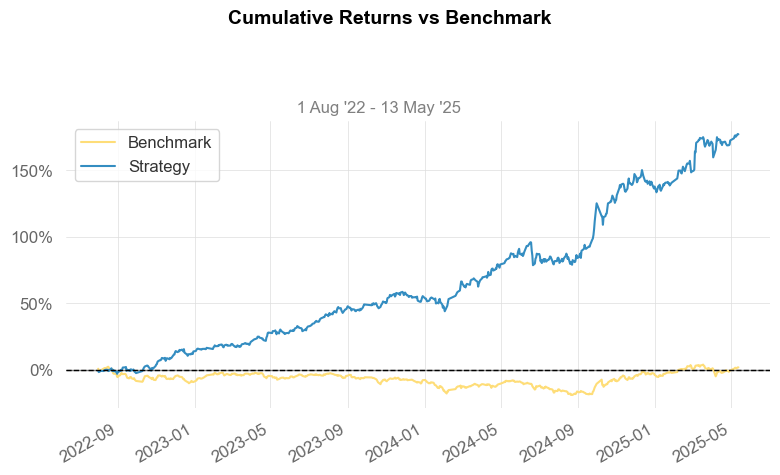

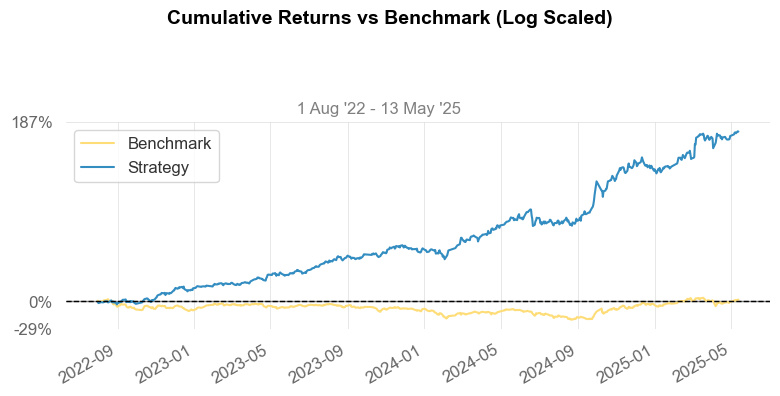

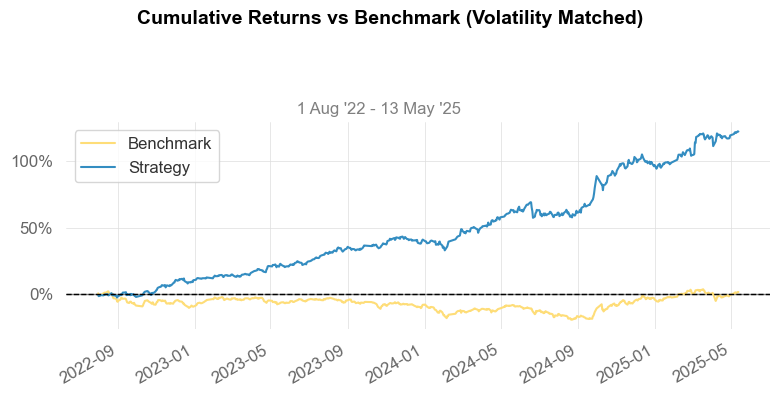

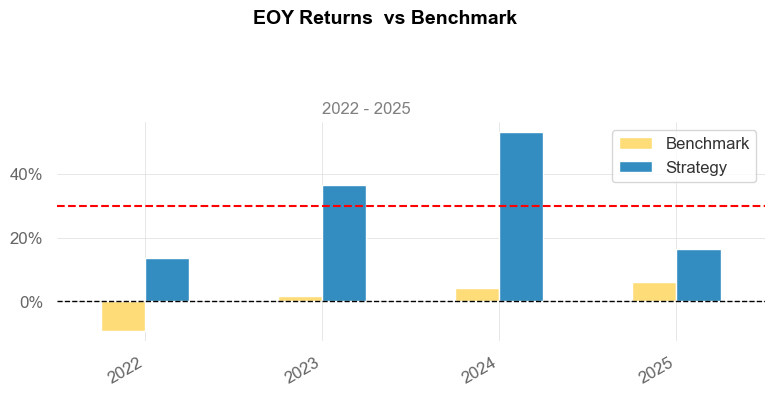

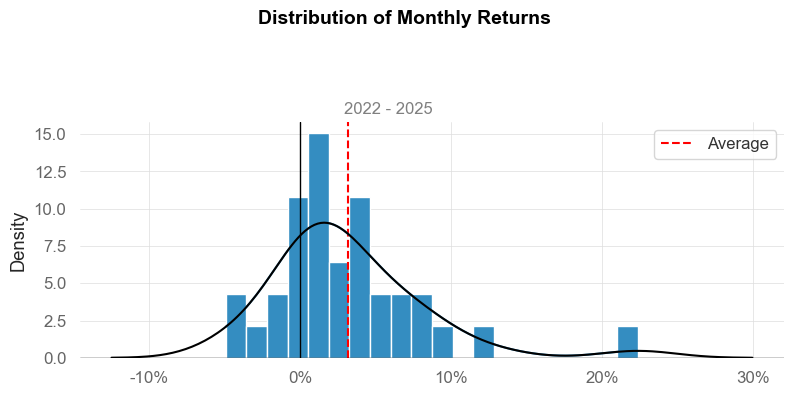

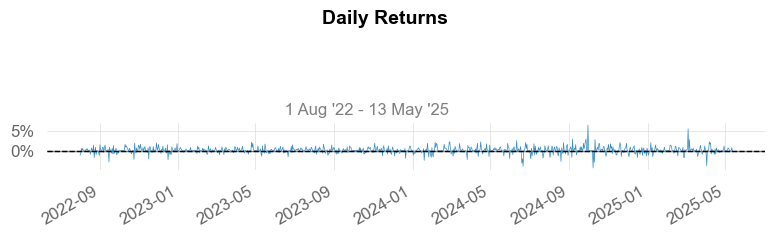

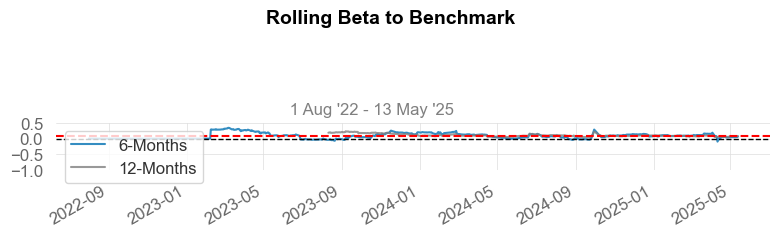

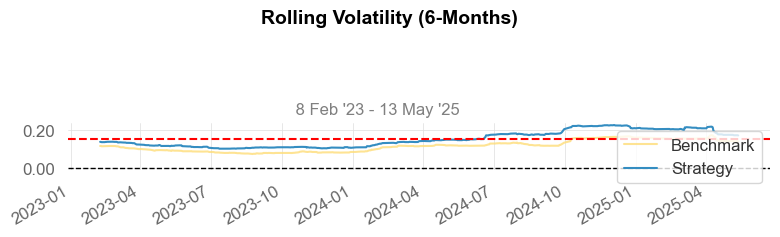

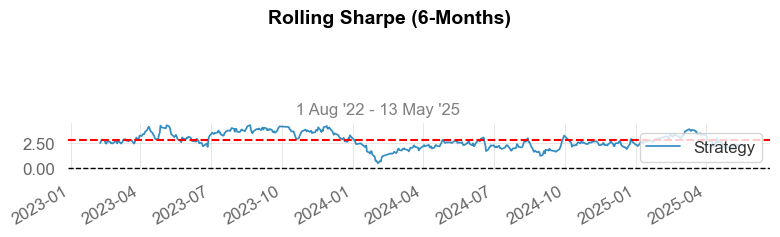

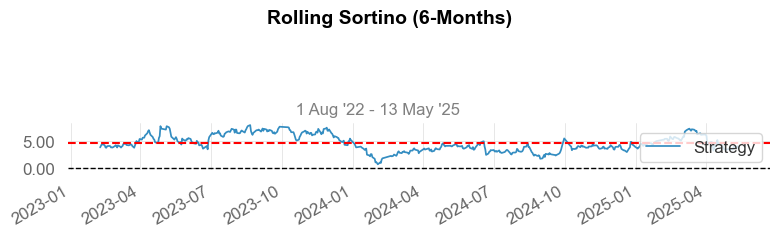

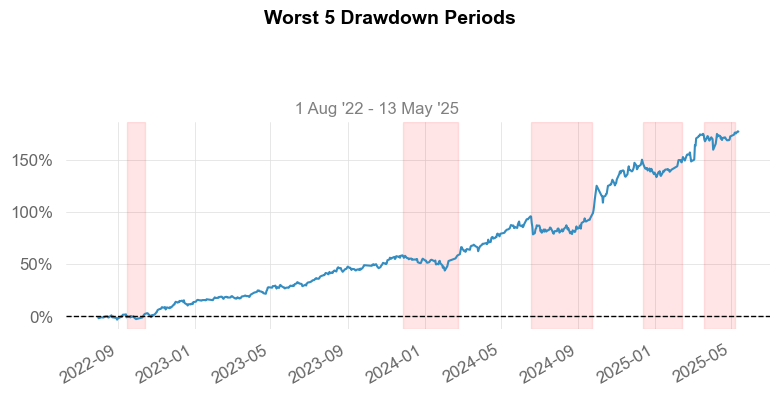

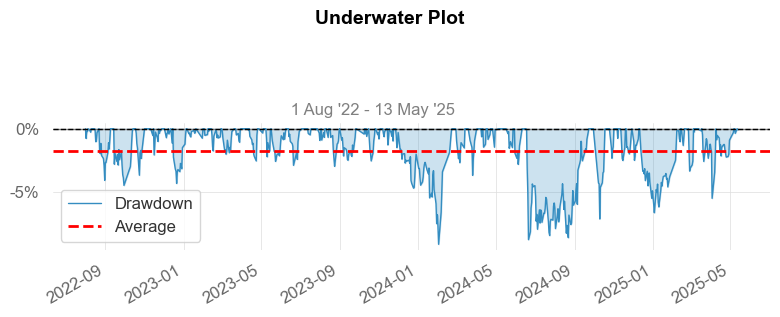

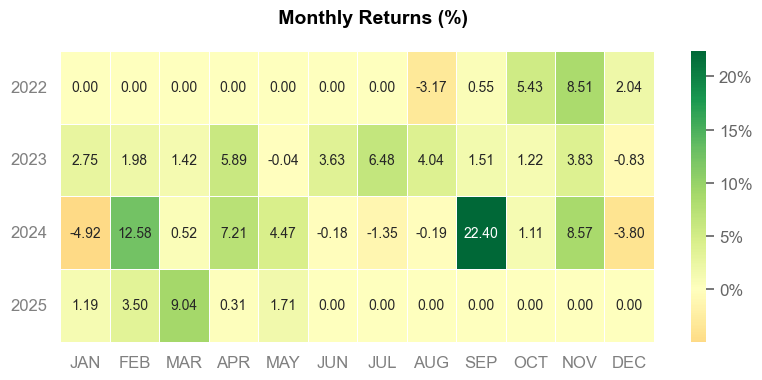

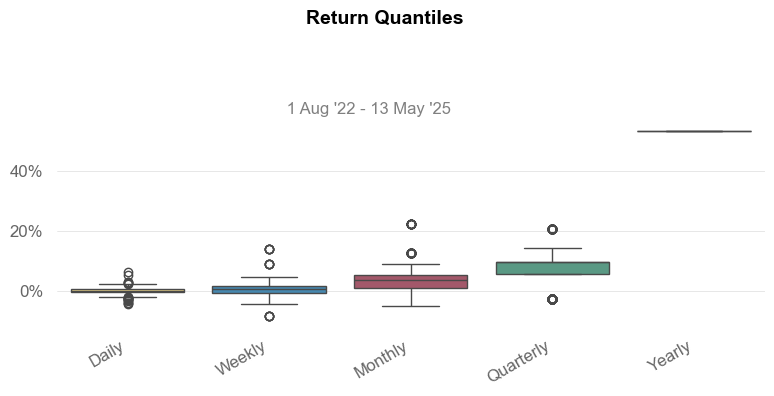


Rebalanced meta-strategy finished. Final Sharpe: nan


In [5]:
print(f"--- Starting Multi-Strategy Backtest with Strategy-Specific Parameters ---")
global_config = CONFIG 

df_cb_raw, df_index = load_data(global_config['cb_data_path'], global_config['index_data_path'])
if df_cb_raw is None or df_index is None:
    print("Fatal Error: Data loading failed. Aborting.")
    exit()

all_individual_net_returns_for_rebalance = {} 
# resolved_strategy_params_list = [] # This list is not strictly needed if we pass dict directly

print("\n--- Processing Individual Strategies ---")
for strategy_definition in tqdm(global_config['strategy_configs'], desc="Processing Strategies"):
    strategy_name = strategy_definition['name']
    factor_weights = strategy_definition['factor_weights']
    
    current_strategy_params = {
        'name': strategy_name,
        'factor_weights': factor_weights,
        'hold_num': get_strategy_param(strategy_definition, global_config, 'hold_num', 20),
        'commission_rate': get_strategy_param(strategy_definition, global_config, 'commission_rate', 2/1000),
        'benchmark_col': get_strategy_param(strategy_definition, global_config, 'benchmark_col', global_config.get('default_benchmark_col')), 
        'stop_profit_pct': get_strategy_param(strategy_definition, global_config, 'stop_profit_pct', 0.03),
        'stop_loss_pct': get_strategy_param(strategy_definition, global_config, 'stop_loss_pct', 0.05),
        'filters': get_strategy_param(strategy_definition, global_config, 'filters', []),
        'dynamic_stop_profit': get_strategy_param(strategy_definition, global_config, 'dynamic_stop_profit', {'enabled': False}),
        'dynamic_stop_loss': get_strategy_param(strategy_definition, global_config, 'dynamic_stop_loss', {'enabled': False}),
        'generate_individual_report': get_strategy_param(strategy_definition, global_config, 'generate_individual_report', False) 
    }
    # resolved_strategy_params_list.append(current_strategy_params.copy()) # Not strictly needed for rebalance if passing dict

    print(f"\nRunning backtest for: {strategy_name}")
    
    df_filtered_strategy = filter_data(df_cb_raw.copy(), 
                                        global_config['start_date'], 
                                        global_config['end_date'], 
                                        current_strategy_params['filters'])
    if df_filtered_strategy is None or df_filtered_strategy[~df_filtered_strategy['filter_out']].empty:
        print(f"Warning: Filtering for {strategy_name} resulted in no data or all data filtered out. Skipping strategy.")
        continue
    
    df_scored = calculate_scores(df_filtered_strategy, factor_weights)
    if df_scored is None:
        print(f"Warning: Scoring failed for {strategy_name}. Skipping.")
        continue

    df_scored_with_rules = apply_dynamic_rules(df_scored, current_strategy_params)
    sp_col = df_scored_with_rules['_sp_col_to_use'].iloc[0] if '_sp_col_to_use' in df_scored_with_rules else 'static_sp_values'
    sl_col = df_scored_with_rules['_sl_col_to_use'].iloc[0] if '_sl_col_to_use' in df_scored_with_rules else 'static_sl_values'

    net_returns, avg_turnover = calculate_strategy_performance(
        df_scored_with_rules, current_strategy_params['hold_num'], current_strategy_params['commission_rate'],
        sp_pct_col=sp_col, sl_pct_col=sl_col, strategy_params=current_strategy_params 
    )

    if net_returns is not None and not net_returns.empty:
        all_individual_net_returns_for_rebalance[strategy_name] = net_returns 
        
        raw_benchmark_series_for_metrics = None
        strat_benchmark_col_name = current_strategy_params['benchmark_col']
        if strat_benchmark_col_name and strat_benchmark_col_name in df_index.columns:
            raw_benchmark_series_for_metrics = df_index[strat_benchmark_col_name]
        else:
            print(f"  Warning: Benchmark column '{strat_benchmark_col_name}' for {strategy_name} (for metrics) not found.")

        metrics = get_performance_metrics(net_returns, raw_benchmark_series_for_metrics, strat_benchmark_col_name, avg_turnover)
        print(f"Metrics for {strategy_name}:") 
        for k, v in metrics.items(): print(f"  {k}: {v}")

        if current_strategy_params['generate_individual_report']:
                generate_full_report_for_strategy(
                strategy_name, current_strategy_params['factor_weights'],
                df_filtered_strategy.copy(), 
                df_index.copy(),
                current_strategy_params, global_config 
            )
    else:
        print(f"Warning: No returns generated for {strategy_name}. Metrics cannot be calculated.")

# Correlation Analysis (can be done if needed, using all_individual_net_returns_for_rebalance)
if len(all_individual_net_returns_for_rebalance) > 1:
    returns_for_corr_df = pd.DataFrame(all_individual_net_returns_for_rebalance).fillna(0)
    common_idx = pd.DatetimeIndex([])
    for col in returns_for_corr_df.columns:
        s_corr = returns_for_corr_df[col]
        if not isinstance(s_corr.index, pd.DatetimeIndex): s_corr.index = pd.to_datetime(s_corr.index)
        s_corr.index = s_corr.index.dropna()
        if not s_corr.index.is_unique: s_corr = s_corr[~s_corr.index.duplicated(keep='first')]
        s_corr.index = s_corr.index.normalize() # CORRECTED: Apply normalize to the index
        returns_for_corr_df[col] = s_corr # Assign back
        common_idx = common_idx.union(s_corr.index)
    
    returns_for_corr_df = returns_for_corr_df.reindex(common_idx.sort_values()).fillna(0)
    correlation_matrix = returns_for_corr_df.corr()
    print("\n\n--- Correlation Matrix of Individual Strategy Daily Returns ---")
    print(correlation_matrix)
else: 
    print("\nNot enough strategy returns for correlation matrix (need at least 2).")


if all_individual_net_returns_for_rebalance: 
    print("\n\n--- Running Multi-Strategy Rebalancing ---")
    rebal_freq = get_strategy_param({}, global_config, 'rebalance_frequency_days', 20) 
    rebalanced_returns, rebalanced_metrics = run_rebalancing_strategy(
        all_individual_net_returns_for_rebalance, 
        df_index.copy(), 
        global_config, 
        rebal_freq
    )
    if rebalanced_returns is not None:
        print(f"\nRebalanced meta-strategy finished. Final Sharpe: {rebalanced_metrics.get('Sharpe', 'N/A')}")
else: 
    print("\nNo valid individual strategy returns available for rebalancing.")